# I. Preparation

In [1]:
import os
import h5py
import time
import itertools

from math import log, sqrt
from statistics import stdev, variance, mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
from scipy.stats import ttest_ind

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

from fooof import FOOOF, FOOOFGroup
from fooof.plts.spectra import plot_spectrum, plot_spectrum_shading, plot_spectra, plot_spectra_shading
from fooof.analysis import get_band_peak_fm, get_band_peak_fg
from fooof.plts.periodic import plot_peak_fits, plot_peak_params
from fooof.plts.aperiodic import plot_aperiodic_params, plot_aperiodic_fits
from fooof.objs.utils import combine_fooofs

from neurodsp.filt import filter_signal
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum

## 1. Function to read .mat files

In [2]:
def read_matlab(filename):
    def conv(path=''):
        p = path or '/'
        paths[p] = ret = {}
        for k, v in f[p].items():
            if type(v).__name__ == 'Group':
                ret[k] = conv(f'{path}/{k}')  # Nested struct
                continue
            v = v[()]  # It's a Numpy array now
            if v.dtype == 'object':
                # HDF5ObjectReferences are converted into a list of actual pointers
                ret[k] = [r and paths.get(f[r].name, f[r].name) for r in v.flat]
            else:
                # Matrices and other numeric arrays
                ret[k] = v if v.ndim < 2 else v.swapaxes(-1, -2)
        return ret

    paths = {}
    with h5py.File(filename, 'r') as f:
        return conv()

## 2. Parameters that can be changed

In [3]:
# Days
days = ('/Day1', '/Day2')

# Subjects
subjects = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 
            'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 
            'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30']

In [4]:
# Parieto, parieto-occipital and occipital channels
channels = (17,18,19,20,21,22,23,24,25,26,27,29,30)
n_channels = 13

In [5]:
table = 5

# Frequency range to fit FOOOF model: Low, Mid, or High
fr = (30,50)

# Frequency range from which to collect Gaussians
bn = (38,44)

## 3. Parameters that should stay fixed

In [6]:
# Sampling rate
fs = 200

# nperseg
nperseg = 500

# Set peak_width_limits
pwl = [2, 4]

# Set max_n_peaks
mnp = 5

# Set peak_threshold
pt = 2 

# Initialize dataframe to store variables
df = pd.DataFrame([], index = [], columns = ['subject', 'day', 'target', \
                                             'offset', 'knee', 'exponent', \
                                             'CF', 'PW', 'BW', 'n_peaks', \
                                             'r_squared', 'error'])

# Colors
colors = ['blue', 'yellow', 'green', 'red']

# II. Fourier transform and FOOOF

In [7]:
## Read EEG, calculate PSD (Welch), fit FOOOF

tic = time.time()
for subject in subjects: 
    for day in days:
        # Initialize per target, average over trials and channels
        powers_50 = np.empty((0, int(nperseg//2)+1), float)
        powers_55 = np.empty((0, int(nperseg//2)+1), float)
        powers_60 = np.empty((0, int(nperseg//2)+1), float)
        powers_65 = np.empty((0, int(nperseg//2)+1), float)
        powers_210 = np.empty((0, int(nperseg//2)+1), float)
        powers_215 = np.empty((0, int(nperseg//2)+1), float)
        powers_220 = np.empty((0, int(nperseg//2)+1), float)
        powers_225 = np.empty((0, int(nperseg//2)+1), float)
        powers_400 = np.empty((0, int(nperseg//2)+1), float)
        powers_405 = np.empty((0, int(nperseg//2)+1), float)
        powers_410 = np.empty((0, int(nperseg//2)+1), float)
        powers_415 = np.empty((0, int(nperseg//2)+1), float)

        # Change working directory
        original = os.getcwd()
        os.chdir("C:/Users/ThinkPad/Desktop/Thesis/Data/"+subject+day)

        # Giving directory name
        folderdir = 'C:/Users/ThinkPad/Desktop/Thesis/Data/'+subject+day

        # Giving file extensions
        ext = ('.mat')

        # Iterating over directory
        for path, dirc, files in os.walk(folderdir):
            for file in files:
                if file.endswith(ext) and file.startswith('cnt'):
                    print(subject, day, file)

                    # LOW, MID, or HIGH
                    level = file[4:-7]

                    # Session 1, or session 2
                    session = file[-6]

                    # Read data
                    data = read_matlab(file)['cnt']['x']

                    # Read timestamps 
                    timestamps = (read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['time'])[0]

                    # Read stimuli order
                    order_stimuli = read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['event']['desc']

                    for trial, timestamp in enumerate(timestamps):   
                        if trial%2 == False:
                            start = int(timestamp)
                        else:
                            stop = int(timestamp)

                            for channel in channels:
#                                 # Apply bandpass filter
#                                 data[:,channel] = filter_signal(data[:,channel], fs, 'bandpass', f_range=fr)

                                # Splice data according to timestamps
                                sig = data[:,channel][start:stop]
                                times = create_times(len(sig)/fs, fs)

#                                 # Plot EEG 
#                                 fig, ax = plt.subplots(figsize=[15, 5])
#                                 plot_time_series(times, sig, xlim=[0,len(sig)/fs], ax=ax)
#                                 plt.show()                                

                                # Welch FFT: calculate mean of spectrogram
                                freq, power = signal.welch(sig, fs, window='hann', average='mean', nperseg=nperseg,\
                                                          noverlap=450, detrend='constant')

                                # Append power to previous powers
                                if level=='LOW':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_50 = np.append(powers_50, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_55 = np.append(powers_55, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_60 = np.append(powers_60, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_65 = np.append(powers_65, power.reshape(1, len(freq)), axis=0)
                                elif level=='MID':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_210 = np.append(powers_210, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_215 = np.append(powers_215, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_220 = np.append(powers_220, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_225 = np.append(powers_225, power.reshape(1, len(freq)), axis=0)
                                elif level=='HIGH':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_400 = np.append(powers_400, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_405 = np.append(powers_405, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_410 = np.append(powers_410, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_415 = np.append(powers_415, power.reshape(1, len(freq)), axis=0)

        # Fit FOOOF model per target
        for (powers, target) in zip((powers_400, powers_405, powers_410, powers_415), \
                                    (400, 405, 410, 415)):
            # FOOOF object: initialize, fit and print results
            fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
            fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
            fm.print_results()
#             fig, ax = plt.subplots(figsize=[15, 5])
#             fm.plot(plot_peaks='line-shade', ax=ax)
#             plt.show()

            # Save metadata, FOOOF parameters and results
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=True)[0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass

# Typecast dataframe
df[['subject', 'day', 'target']] = df[['subject', 'day', 'target']].astype('category')
df['n_peaks'] = df['n_peaks'].astype('int32')
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']] = \
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']].astype('float32')

# Change working directory back
os.chdir(original)

print(f'Done in {time.time()-tic} seconds')

S1 /Day1 cnt_HIGH(1).mat
S1 /Day1 cnt_HIGH(2).mat
S1 /Day1 cnt_LOW(1).mat
S1 /Day1 cnt_LOW(2).mat
S1 /Day1 cnt_MID(1).mat
S1 /Day1 cnt_MID(2).mat
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 30 - 50 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -4.2418, -1.0013, 0.0005                                     
                                                              

# III. Descriptive statistics
## 1. Summary

In [8]:
# Data types
display(df.dtypes)

subject      category
day          category
target       category
offset        float32
knee          float32
exponent      float32
CF            float32
PW            float32
BW            float32
n_peaks         int32
r_squared     float32
error         float32
dtype: object

In [9]:
# Head of dataframe
display(df.head(n=5))

,subject,day,target,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
0,S1,/Day1,400,-4.241769,-1.001322,0.000485,40.789368,0.144279,2.350276,1,0.663628,0.039957
1,S1,/Day1,405,-4.220107,-1.001587,0.000558,40.508125,0.133994,2.000000,2,0.699494,0.038891
2,S1,/Day2,405,-2.717287,-0.996706,0.000669,39.472469,0.335811,2.020042,2,0.631220,0.053354
3,S1,/Day2,410,-3.778546,-1.001125,0.000554,41.387703,0.113572,2.000000,4,0.494326,0.034774
4,S2,/Day1,400,-4.188694,-1.001813,0.000565,39.795048,0.130524,2.000000,2,0.904317,0.038631


In [10]:
# Summary statistics
display(pd.concat([df.describe(),\
                   pd.DataFrame(df.skew(), columns=['skewness']).transpose(),\
                   pd.DataFrame(df.kurtosis(), columns=['kurtosis']).transpose()]).round(2))

,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
count,202.00,2.020000e+02,202.00,202.00,202.00,202.00,202.00,202.00,202.00
mean,-2.48,5.225104e+06,0.43,40.77,0.13,2.28,1.95,0.82,0.04
std,2.68,5.229331e+07,0.91,1.15,0.08,0.61,0.83,0.18,0.02
min,-4.83,-2.096512e+04,-0.13,38.06,0.03,2.00,1.00,0.03,0.02
25%,-4.29,-2.010000e+00,0.00,40.03,0.08,2.00,1.00,0.76,0.03
50%,-3.89,-1.000000e+00,0.00,40.80,0.11,2.00,2.00,0.89,0.04
75%,-0.95,-1.000000e+00,0.42,41.35,0.17,2.00,2.00,0.95,0.05
max,8.35,5.285643e+08,5.37,43.99,0.49,4.00,4.00,0.98,0.14
skewness,1.59,9.970000e+00,2.88,0.44,1.87,2.07,0.47,-2.12,2.24
kurtosis,2.18,9.846000e+01,9.11,0.66,4.29,2.73,-0.53,5.09,8.41


## 2. Univariate plots

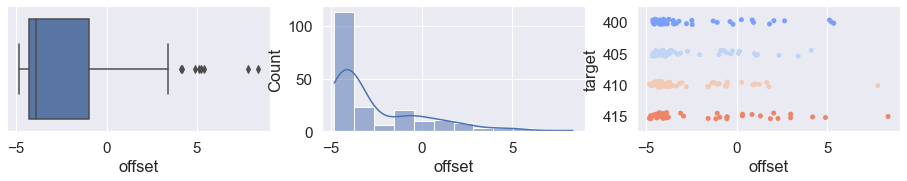

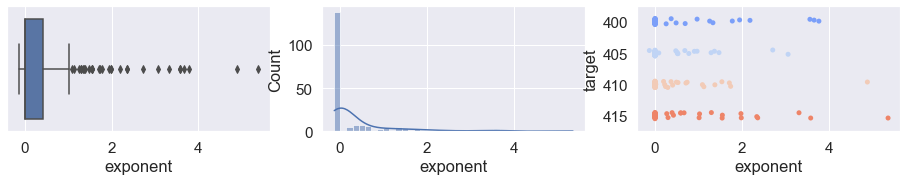

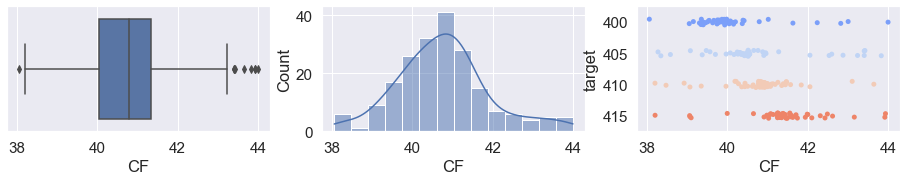

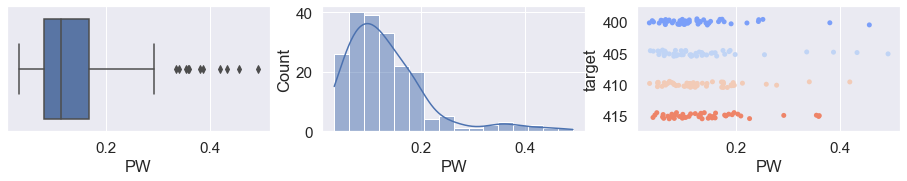

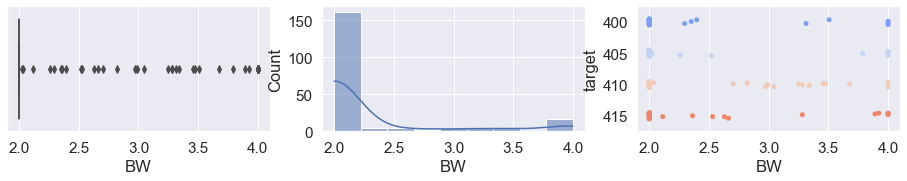

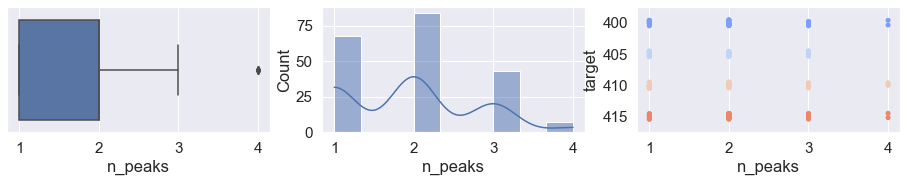

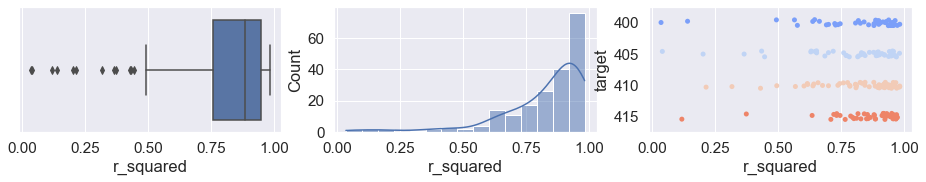

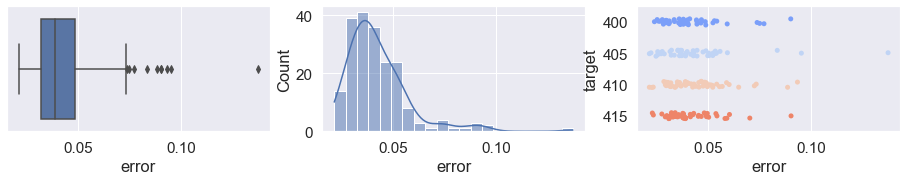

Done in 4.188s


In [11]:
tic = time.time()

df_num = df[['offset', 'exponent', 'CF', 'PW', 'BW', 'n_peaks', 'r_squared', 'error']]

for index, column in enumerate(df_num):
    sns.set(font_scale = 1.38)
    fig, ax = plt.subplots(1, 3, figsize=[16, 2.3])
    sns.boxplot(data=df_num, x=column, ax=ax[0])
    sns.histplot(data=df_num, x=column, kde=True,  ax=ax[1]) 
    sns.stripplot(data=df_num, x=column, y=df['target'], palette='coolwarm', ax=ax[2])
    plt.show()

toc = time.time()
print(f"Done in {toc - tic:.3f}s")

## 3. Bivariate plots

C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnin

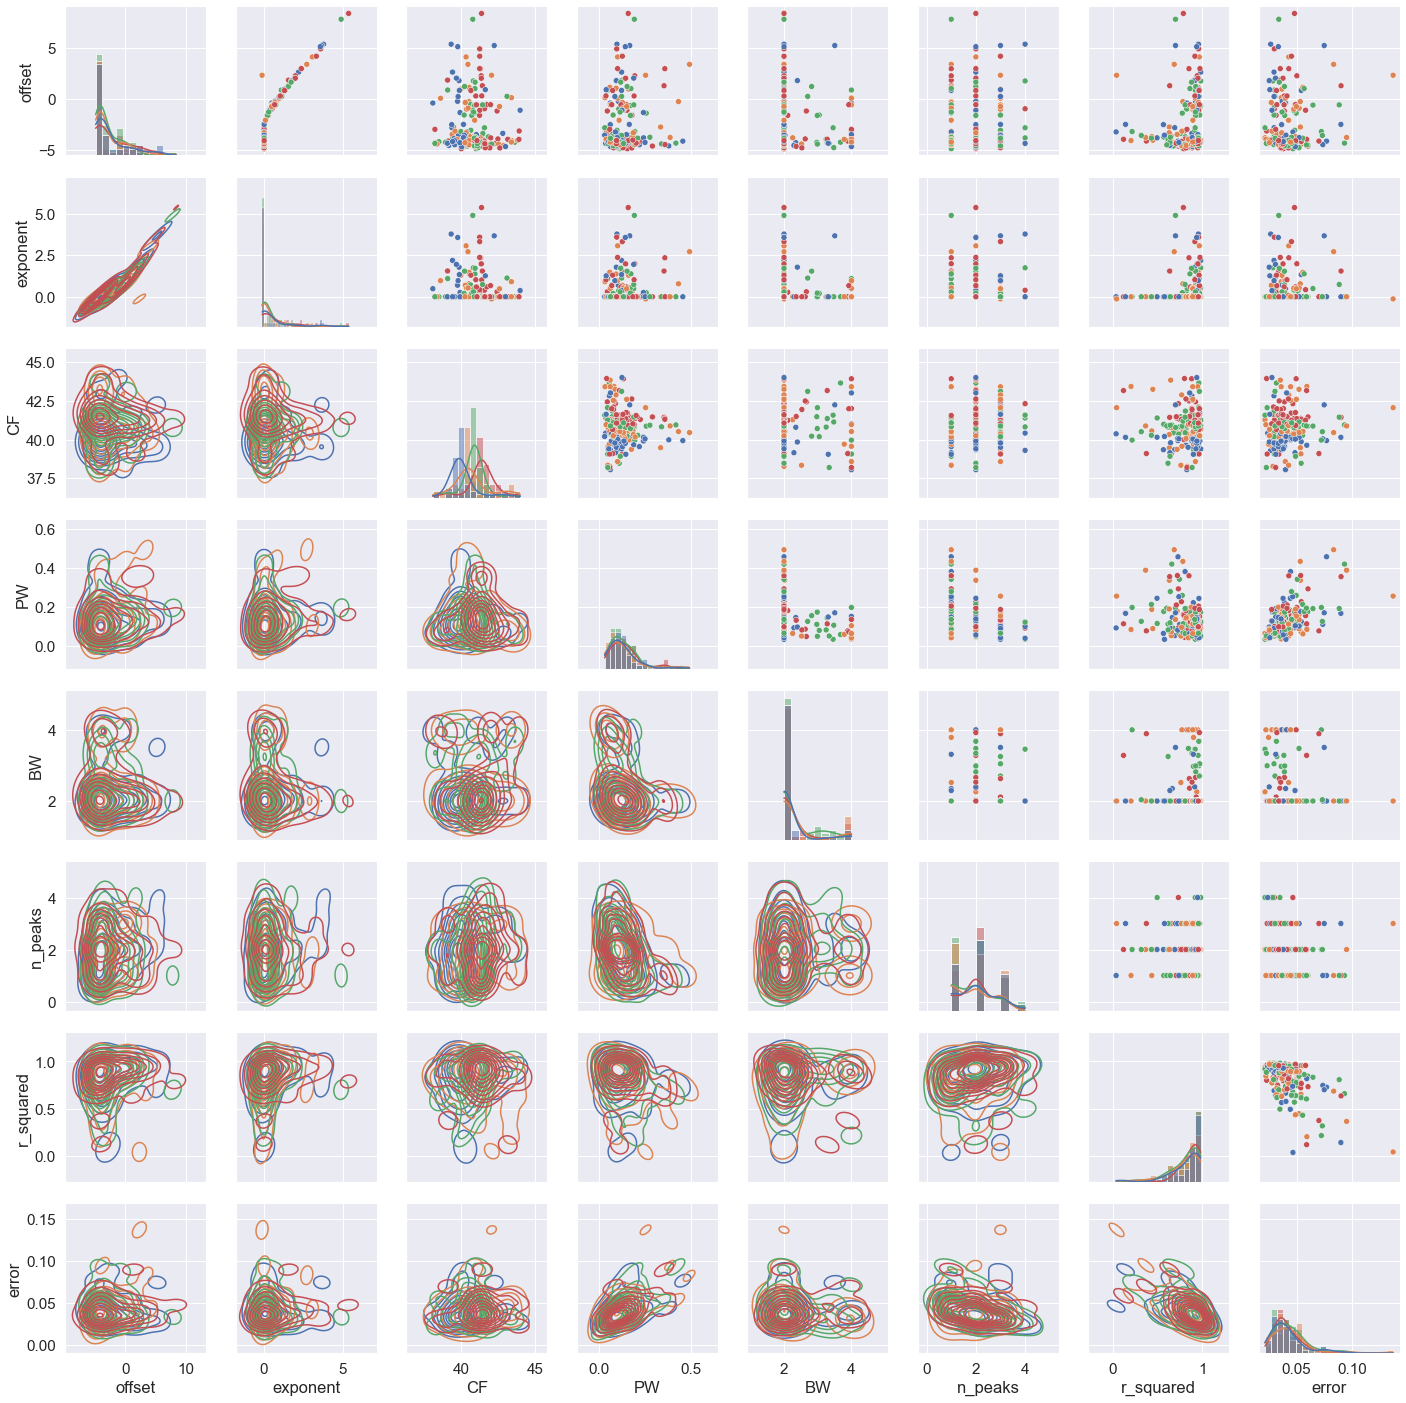

Done in 21.858s


In [12]:
tic = time.time()

g = sns.PairGrid(df_num)
g.map_upper(sns.scatterplot, hue=df['target'])
g.map_lower(sns.kdeplot, hue=df['target'], cmap = "Blues_d")
g.map_diag(sns.histplot, hue=df['target'], kde=True)
plt.show()

toc = time.time()
print(f"Done in {toc - tic:.3f}s")

## 4. Correlation matrix

,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
offset,1.00,0.40,0.93,-0.01,0.11,-0.01,0.09,0.15,0.06
knee,0.40,1.00,0.52,0.03,0.05,-0.05,-0.05,-0.04,-0.01
exponent,0.93,0.52,1.00,-0.01,0.11,-0.05,0.05,0.18,-0.00
CF,-0.01,0.03,-0.01,1.00,-0.03,0.07,0.12,-0.01,0.06
PW,0.11,0.05,0.11,-0.03,1.00,-0.26,-0.34,-0.23,0.54
BW,-0.01,-0.05,-0.05,0.07,-0.26,1.00,0.05,0.01,-0.11
n_peaks,0.09,-0.05,0.05,0.12,-0.34,0.05,1.00,0.09,-0.24
r_squared,0.15,-0.04,0.18,-0.01,-0.23,0.01,0.09,1.00,-0.59
error,0.06,-0.01,-0.00,0.06,0.54,-0.11,-0.24,-0.59,1.00


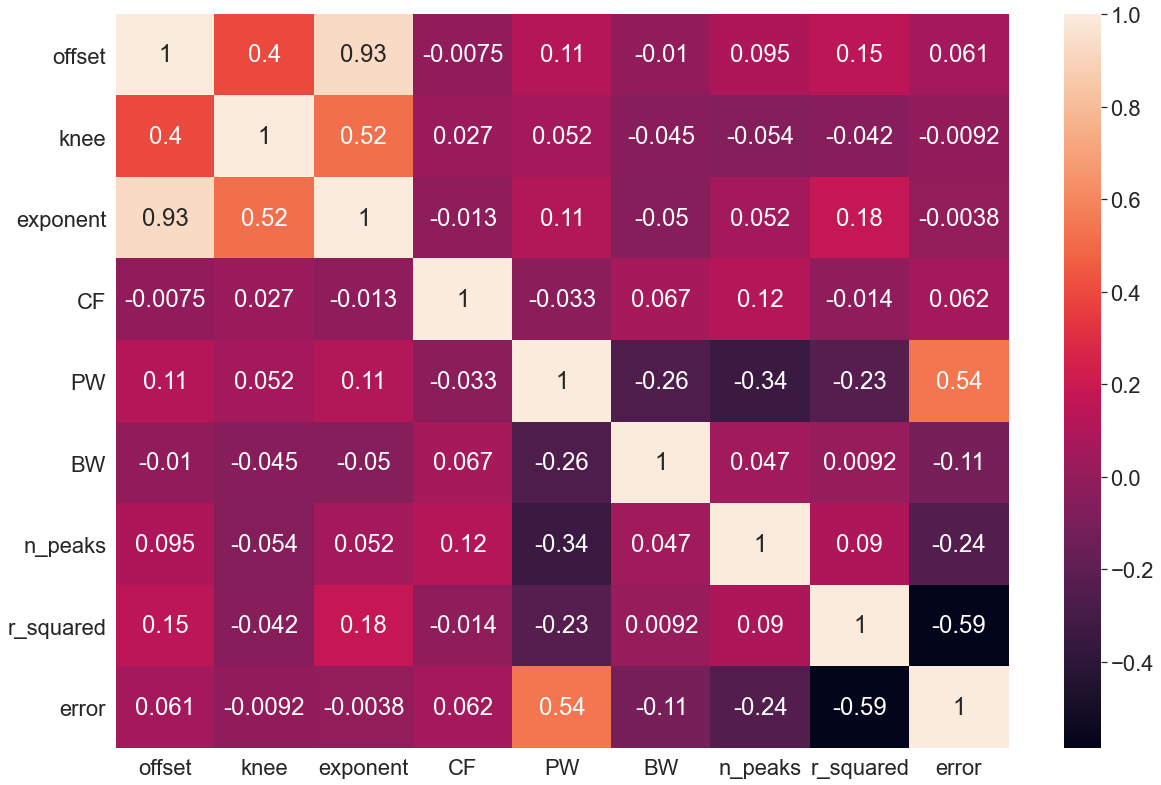

In [13]:
display(df.corr().round(2))

sns.set(font_scale = 2)
fig, heat = plt.subplots(figsize=(20,13.5))
heat = sns.heatmap(df.corr(), annot=True)
plt.show()

# IV. Classification
## Assign variables

In [14]:
# Number of observations
n_obs = len(df)

# Assign target and serie
y = df['target'].to_numpy().ravel()

# Select features
X = df.drop(columns=['subject', 'day', 'target']).to_numpy()

# Initialize dataframe
performance = pd.DataFrame([], index = [], columns = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table'])

## 1. Logistic regression

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: 0, Score: -0.11393
Feature: 1, Score: 762.73909
Feature: 2, Score: 0.36743
Feature: 3, Score: -0.97921
Feature: 4, Score: -0.10112
Feature: 5, Score: -0.42517
Feature: 6, Score: 0.23749
Feature: 7, Score: -0.17426
Feature: 8, Score: 0.09714


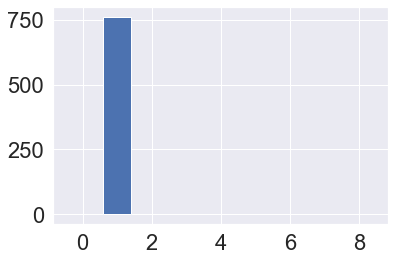

              precision    recall  f1-score   support

         400       0.70      0.58      0.64        12
         405       0.20      0.25      0.22         8
         410       0.18      0.17      0.17        12
         415       0.40      0.44      0.42         9

    accuracy                           0.37        41
   macro avg       0.37      0.36      0.36        41
weighted avg       0.38      0.37      0.37        41

Feature: 0, Score: 0.26056
Feature: 1, Score: -1308.75587
Feature: 2, Score: -0.35109
Feature: 3, Score: -0.67934
Feature: 4, Score: 0.00581
Feature: 5, Score: -0.13277
Feature: 6, Score: 0.11880
Feature: 7, Score: -0.27175
Feature: 8, Score: -0.33180


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


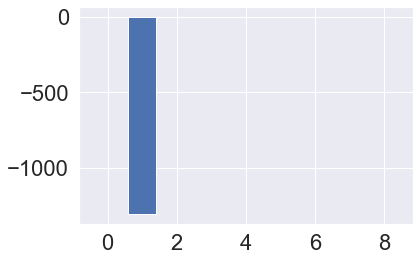

              precision    recall  f1-score   support

         400       0.40      0.36      0.38        11
         405       0.00      0.00      0.00         5
         410       0.00      0.00      0.00        12
         415       0.30      0.23      0.26        13

    accuracy                           0.17        41
   macro avg       0.17      0.15      0.16        41
weighted avg       0.20      0.17      0.18        41

Feature: 0, Score: -0.52485
Feature: 1, Score: 91.77926
Feature: 2, Score: 0.75803
Feature: 3, Score: -0.99171
Feature: 4, Score: -0.16048
Feature: 5, Score: -0.13437
Feature: 6, Score: 0.13920
Feature: 7, Score: -0.08535
Feature: 8, Score: 0.12427


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


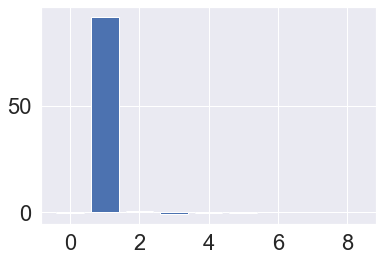

              precision    recall  f1-score   support

         400       0.40      0.44      0.42         9
         405       0.33      0.30      0.32        10
         410       0.25      0.27      0.26        11
         415       0.44      0.40      0.42        10

    accuracy                           0.35        40
   macro avg       0.36      0.35      0.35        40
weighted avg       0.35      0.35      0.35        40

Feature: 0, Score: 0.25373
Feature: 1, Score: 4.40742
Feature: 2, Score: -0.89982
Feature: 3, Score: -0.90371
Feature: 4, Score: 0.07398
Feature: 5, Score: -0.16335
Feature: 6, Score: 0.09683
Feature: 7, Score: 0.17406
Feature: 8, Score: 0.13821


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


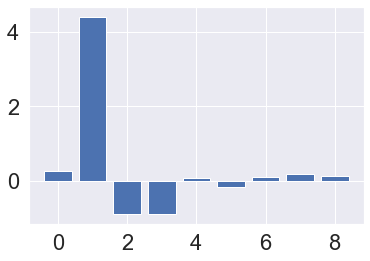

              precision    recall  f1-score   support

         400       0.33      0.30      0.32        10
         405       0.10      0.12      0.11         8
         410       0.45      0.33      0.38        15
         415       0.40      0.57      0.47         7

    accuracy                           0.33        40
   macro avg       0.32      0.33      0.32        40
weighted avg       0.34      0.33      0.33        40

Feature: 0, Score: -0.72658
Feature: 1, Score: -0.56433
Feature: 2, Score: 1.05532
Feature: 3, Score: -0.57377
Feature: 4, Score: -0.00754
Feature: 5, Score: -0.17026
Feature: 6, Score: 0.12279
Feature: 7, Score: -0.04950
Feature: 8, Score: -0.11404


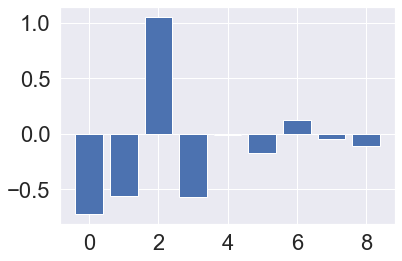

              precision    recall  f1-score   support

         400       0.44      0.33      0.38        12
         405       0.00      0.00      0.00         5
         410       0.36      0.50      0.42         8
         415       0.80      0.53      0.64        15

    accuracy                           0.40        40
   macro avg       0.40      0.34      0.36        40
weighted avg       0.51      0.40      0.44        40



In [15]:
# Split in K folds and standardize
K = 5
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Initialize model
    LR = LogisticRegression(penalty='none', random_state=13)

    # Fit model 
    LR.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = LR.predict(X_test_scaled)
    
    # Summarize feature importance
    importance = LR.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(classification_report(y_pred, y_test))

    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
    
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'log', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True) 

In [16]:
# Variance inflation factors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame([variance_inflation_factor(X_scaled, i) for i in range(9)], 
             columns=['VIF'], \
             index = ['offset', 'knee', 'exponent', 'center of frequency', 'power', 'bandwidth', \
                      'n peaks', 'R2', 'MAE']).round(1)

,VIF
offset,8.4
knee,1.5
exponent,9.6
center of frequency,1.0
power,1.7
bandwidth,1.1
n peaks,1.2
R2,1.7
MAE,2.3


## 2. Ridge classifier

Feature: 0, Score: -0.03411
Feature: 1, Score: -0.09828
Feature: 2, Score: 0.12817
Feature: 3, Score: -0.26937
Feature: 4, Score: -0.04862
Feature: 5, Score: -0.09819
Feature: 6, Score: 0.07483
Feature: 7, Score: -0.07678
Feature: 8, Score: 0.01093


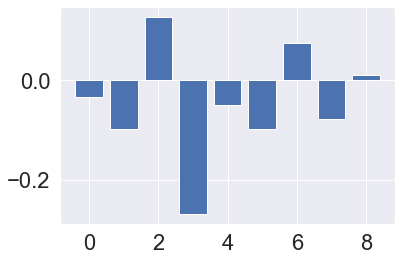

Alpha: 2.320794416806396
              precision    recall  f1-score   support

         400       0.60      0.55      0.57        11
         405       0.20      0.33      0.25         6
         410       0.18      0.15      0.17        13
         415       0.50      0.45      0.48        11

    accuracy                           0.37        41
   macro avg       0.37      0.37      0.37        41
weighted avg       0.38      0.37      0.37        41

Feature: 0, Score: 0.07817
Feature: 1, Score: -0.01215
Feature: 2, Score: -0.11842
Feature: 3, Score: -0.25211
Feature: 4, Score: 0.00986
Feature: 5, Score: -0.03014
Feature: 6, Score: 0.06287
Feature: 7, Score: -0.10301
Feature: 8, Score: -0.14035


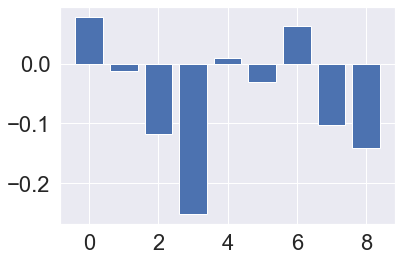

Alpha: 0.10772173450159434
              precision    recall  f1-score   support

         400       0.40      0.36      0.38        11
         405       0.00      0.00      0.00         5
         410       0.09      0.08      0.08        13
         415       0.30      0.25      0.27        12

    accuracy                           0.20        41
   macro avg       0.20      0.17      0.18        41
weighted avg       0.22      0.20      0.21        41

Feature: 0, Score: -0.15026
Feature: 1, Score: -0.10393
Feature: 2, Score: 0.24744
Feature: 3, Score: -0.31944
Feature: 4, Score: -0.07513
Feature: 5, Score: -0.03316
Feature: 6, Score: 0.05419
Feature: 7, Score: -0.02701
Feature: 8, Score: 0.02737


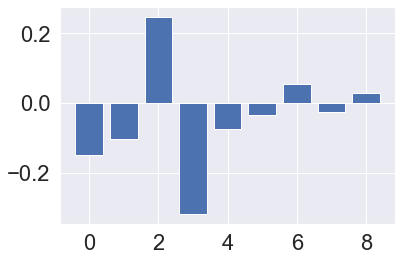

Alpha: 2.320794416806396
              precision    recall  f1-score   support

         400       0.50      0.38      0.43        13
         405       0.22      0.29      0.25         7
         410       0.17      0.33      0.22         6
         415       0.56      0.36      0.43        14

    accuracy                           0.35        40
   macro avg       0.36      0.34      0.34        40
weighted avg       0.42      0.35      0.37        40

Feature: 0, Score: -0.05288
Feature: 1, Score: 0.16459
Feature: 2, Score: -0.03416
Feature: 3, Score: -0.20190
Feature: 4, Score: 0.01367
Feature: 5, Score: -0.02590
Feature: 6, Score: 0.02061
Feature: 7, Score: 0.00638
Feature: 8, Score: 0.02218


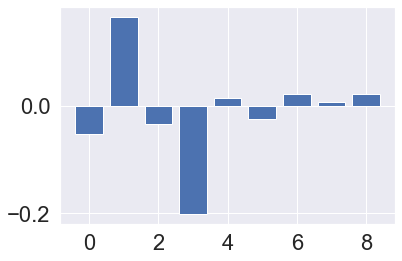

Alpha: 50.0
              precision    recall  f1-score   support

         400       0.33      0.30      0.32        10
         405       0.10      0.17      0.12         6
         410       0.45      0.45      0.45        11
         415       0.70      0.54      0.61        13

    accuracy                           0.40        40
   macro avg       0.40      0.36      0.38        40
weighted avg       0.45      0.40      0.42        40

Feature: 0, Score: -0.00969
Feature: 1, Score: -0.06744
Feature: 2, Score: 0.07418
Feature: 3, Score: -0.16724
Feature: 4, Score: -0.01642
Feature: 5, Score: -0.05331
Feature: 6, Score: 0.03584
Feature: 7, Score: 0.00448
Feature: 8, Score: -0.03835


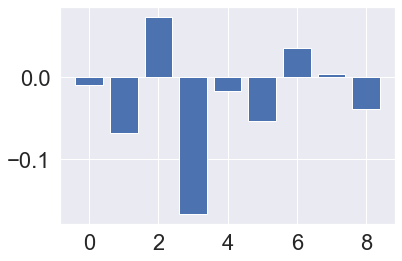

Alpha: 50.0
              precision    recall  f1-score   support

         400       0.56      0.38      0.45        13
         405       0.00      0.00      0.00         1
         410       0.36      0.31      0.33        13
         415       0.70      0.54      0.61        13

    accuracy                           0.40        40
   macro avg       0.40      0.31      0.35        40
weighted avg       0.53      0.40      0.45        40



In [17]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize Ridge hyperparameter λ 
    hyperparameters = {"alpha": 10**np.linspace(10,-2,10)*0.5} 
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RidgeClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    RC = RidgeClassifier(alpha=Grid.best_params_['alpha'], random_state=13)

    # Fit model 
    RC.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = RC.predict(X_test_scaled)

    # Summarize feature importance
    importance = RC.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print("Alpha:",Grid.best_params_['alpha'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
         
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'ridge', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 3. K-nearest neighbors

Feature: 0, Score: 0.00000
Feature: 1, Score: -0.01951
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


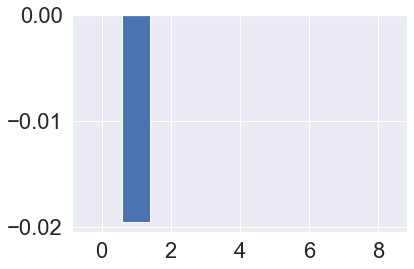

n_neighbors: 6
              precision    recall  f1-score   support

         400       0.40      0.33      0.36        12
         405       0.30      0.30      0.30        10
         410       0.36      0.24      0.29        17
         415       0.00      0.00      0.00         2

    accuracy                           0.27        41
   macro avg       0.27      0.22      0.24        41
weighted avg       0.34      0.27      0.30        41

Feature: 0, Score: 0.00976
Feature: 1, Score: -0.09268
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.01463
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00488
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


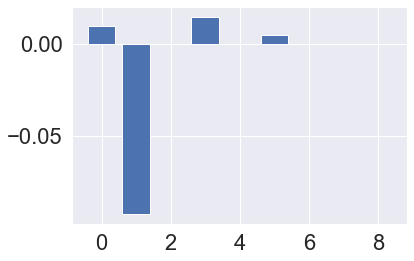

n_neighbors: 3
              precision    recall  f1-score   support

         400       0.50      0.33      0.40        15
         405       0.20      0.18      0.19        11
         410       0.45      0.62      0.53         8
         415       0.40      0.57      0.47         7

    accuracy                           0.39        41
   macro avg       0.39      0.43      0.40        41
weighted avg       0.39      0.39      0.38        41

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


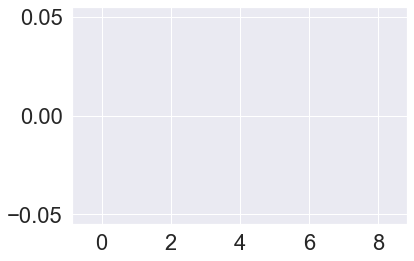

n_neighbors: 10
              precision    recall  f1-score   support

         400       0.60      0.46      0.52        13
         405       0.00      0.00      0.00         3
         410       0.42      0.33      0.37        15
         415       0.22      0.22      0.22         9

    accuracy                           0.33        40
   macro avg       0.31      0.25      0.28        40
weighted avg       0.40      0.33      0.36        40

Feature: 0, Score: 0.02500
Feature: 1, Score: 0.04500
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.01500
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


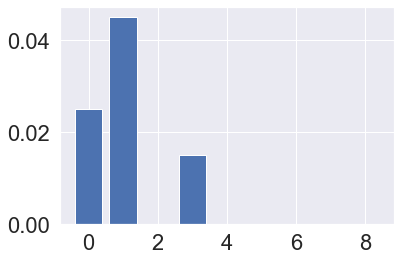

n_neighbors: 10
              precision    recall  f1-score   support

         400       0.33      0.30      0.32        10
         405       0.00      0.00      0.00         6
         410       0.18      0.12      0.15        16
         415       0.40      0.50      0.44         8

    accuracy                           0.23        40
   macro avg       0.23      0.23      0.23        40
weighted avg       0.24      0.23      0.23        40

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00500
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


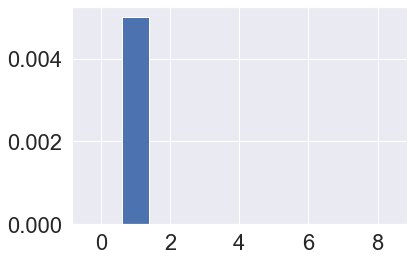

n_neighbors: 14
              precision    recall  f1-score   support

         400       0.44      0.31      0.36        13
         405       0.10      0.25      0.14         4
         410       0.27      0.25      0.26        12
         415       0.40      0.36      0.38        11

    accuracy                           0.30        40
   macro avg       0.30      0.29      0.29        40
weighted avg       0.35      0.30      0.32        40



In [18]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize hyperparameter K
    hyperparameters = {'n_neighbors':[i for i in range(1,20)]}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(KNeighborsClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
        
    # Initialize model
    KNN = KNeighborsClassifier(n_neighbors=Grid.best_params_['n_neighbors'])
    
    # Fit model 
    KNN.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = KNN.predict(X_test_scaled)
    
    # Summarize feature importance
    results = permutation_importance(KNN, X_test, y_test, scoring='accuracy')
    importance = results.importances_mean
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print('n_neighbors:',Grid.best_params_['n_neighbors'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'KNN', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 4. Multi-layer perceptron

In [19]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Optimize hyperparameters
    hyperparameters = {'activation':['identity', 'logistic', 'tanh', 'relu'], 'solver':['lbfgs', 'sgd', 'adam']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(MLPClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    MLP = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500, activation = Grid.best_params_['activation'], \
                        solver=Grid.best_params_['solver'], random_state=13)

    # Fit model 
    MLP.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = MLP.predict(X_test_scaled)

    # Output
    print(f"\033[1mActivation function: \033[0m{Grid.best_params_['activation']}")
    print(f"\033[1mSolver: \033[0m{Grid.best_params_['solver']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
     
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'MLP', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   
display(performance)

Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         400       0.60      0.55      0.57        11
         405       0.20      0.33      0.25         6
         410       0.36      0.29      0.32        14
         415       0.30      0.30      0.30        10

    accuracy                           0.37        41
   macro avg       0.37      0.37      0.36        41
weighted avg       0.39      0.37      0.37        41

Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         400       0.60      0.67      0.63         9
         405       0.50      0.42      0.45        12
         410       0.55      0.43      0.48        14
         415       0.20      0.33      0.25         6

    accuracy                           0.46        41
   macro avg       0.46      0.46      0.45        41
weighted avg       0.49      0.46      0.47        41

Activation function: logistic
Solver: lbfg

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Activation function: identity
Solver: sgd
              precision    recall  f1-score   support

         400       0.44      0.36      0.40        11
         405       0.10      0.12      0.11         8
         410       0.36      0.36      0.36        11
         415       0.60      0.60      0.60        10

    accuracy                           0.38        40
   macro avg       0.38      0.36      0.37        40
weighted avg       0.39      0.38      0.38        40

Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         400       0.56      0.62      0.59         8
         405       0.40      0.44      0.42         9
         410       0.27      0.27      0.27        11
         415       0.60      0.50      0.55        12

    accuracy                           0.45        40
   macro avg       0.46      0.46      0.46        40
weighted avg       0.46      0.45      0.45        40



,accuracy,precision,recall,classifier,n_channels,table
0,0.37,0.38,0.37,log,13,5
1,0.17,0.2,0.17,log,13,5
2,0.35,0.35,0.35,log,13,5
3,0.33,0.34,0.33,log,13,5
4,0.4,0.51,0.4,log,13,5
5,0.37,0.38,0.37,ridge,13,5
6,0.2,0.22,0.2,ridge,13,5
7,0.35,0.42,0.35,ridge,13,5
8,0.4,0.45,0.4,ridge,13,5
9,0.4,0.53,0.4,ridge,13,5


## 5. Random forest

Feature: 0, Score: 0.08655
Feature: 1, Score: 0.08392
Feature: 2, Score: 0.09005
Feature: 3, Score: 0.34392
Feature: 4, Score: 0.10985
Feature: 5, Score: 0.04984
Feature: 6, Score: 0.03669
Feature: 7, Score: 0.09527
Feature: 8, Score: 0.10391


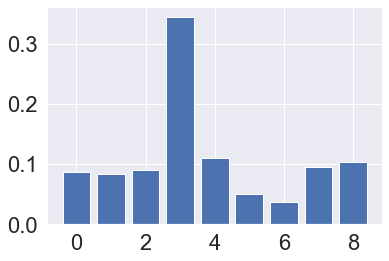

Number of trees: 200
Maximum depth: 55
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         400       0.60      0.60      0.60        10
         405       0.40      0.67      0.50         6
         410       0.36      0.36      0.36        11
         415       0.50      0.36      0.42        14

    accuracy                           0.46        41
   macro avg       0.47      0.50      0.47        41
weighted avg       0.47      0.46      0.46        41

Feature: 0, Score: 0.08222
Feature: 1, Score: 0.08572
Feature: 2, Score: 0.08860
Feature: 3, Score: 0.32411
Feature: 4, Score: 0.11985
Feature: 5, Score: 0.04923
Feature: 6, Score: 0.03157
Feature: 7, Score: 0.10411
Feature: 8, Score: 0.11459


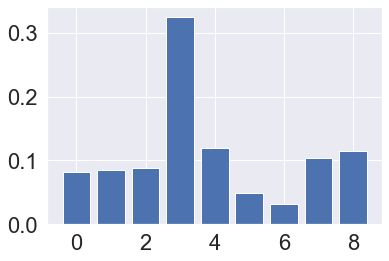

Number of trees: 200
Maximum depth: 100
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         400       0.90      0.69      0.78        13
         405       0.50      0.50      0.50        10
         410       0.27      0.43      0.33         7
         415       0.60      0.55      0.57        11

    accuracy                           0.56        41
   macro avg       0.57      0.54      0.55        41
weighted avg       0.61      0.56      0.58        41

Feature: 0, Score: 0.08662
Feature: 1, Score: 0.07958
Feature: 2, Score: 0.08294
Feature: 3, Score: 0.33251
Feature: 4, Score: 0.11563
Feature: 5, Score: 0.05181
Feature: 6, Score: 0.03511
Feature: 7, Score: 0.11398
Feature: 8, Score: 0.10182


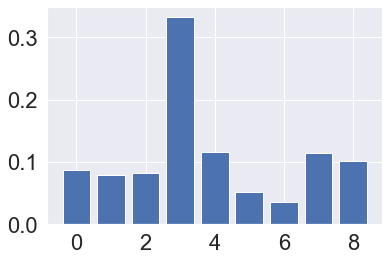

Number of trees: 200
Maximum depth: 77
Maximum features per node split: auto
              precision    recall  f1-score   support

         400       0.80      0.50      0.62        16
         405       0.33      0.33      0.33         9
         410       0.42      0.56      0.48         9
         415       0.22      0.33      0.27         6

    accuracy                           0.45        40
   macro avg       0.44      0.43      0.42        40
weighted avg       0.52      0.45      0.47        40

Feature: 0, Score: 0.09113
Feature: 1, Score: 0.08893
Feature: 2, Score: 0.08870
Feature: 3, Score: 0.34327
Feature: 4, Score: 0.10294
Feature: 5, Score: 0.04944
Feature: 6, Score: 0.03614
Feature: 7, Score: 0.09684
Feature: 8, Score: 0.10262


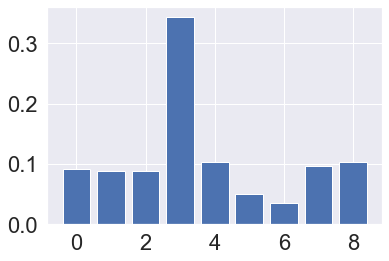

Number of trees: 200
Maximum depth: 100
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         400       0.56      0.83      0.67         6
         405       0.50      0.83      0.62         6
         410       0.55      0.43      0.48        14
         415       0.70      0.50      0.58        14

    accuracy                           0.57        40
   macro avg       0.58      0.65      0.59        40
weighted avg       0.59      0.57      0.57        40

Feature: 0, Score: 0.08622
Feature: 1, Score: 0.08154
Feature: 2, Score: 0.08702
Feature: 3, Score: 0.32452
Feature: 4, Score: 0.10840
Feature: 5, Score: 0.06150
Feature: 6, Score: 0.03474
Feature: 7, Score: 0.10795
Feature: 8, Score: 0.10812


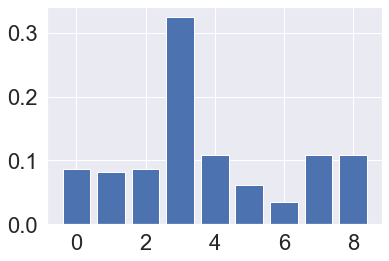

Number of trees: 200
Maximum depth: 10
Maximum features per node split: auto
              precision    recall  f1-score   support

         400       0.78      0.88      0.82         8
         405       0.40      0.50      0.44         8
         410       0.45      0.50      0.48        10
         415       0.80      0.57      0.67        14

    accuracy                           0.60        40
   macro avg       0.61      0.61      0.60        40
weighted avg       0.63      0.60      0.61        40

Done in 754.2312488555908 seconds


In [20]:
tic = time.time()

# Split in K folds
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # Optimize hyperparameters
    hyperparameters = {"n_estimators": [200, 1000, 2000], \
                       "max_depth": [int(x) for x in np.linspace(10, 100, num = 5)],\
                       "max_features": ['auto', 'sqrt']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RandomForestClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train, y_train)
    
    # Initiating a RF classifier
    RFC = RandomForestClassifier(n_estimators = Grid.best_params_['n_estimators'], \
                                max_depth = Grid.best_params_['max_depth'], \
                                max_features = Grid.best_params_['max_features'], random_state = 13)  

    # Fit model
    RFC.fit(X_train, y_train)
  
    # performing predictions on the test dataset
    y_pred = RFC.predict(X_test)
    
    # Summarize feature importance
    importance = RFC.feature_importances_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(f"\033[1mNumber of trees: \033[0m{Grid.best_params_['n_estimators']}")
    print(f"\033[1mMaximum depth: \033[0m{Grid.best_params_['max_depth']}")
    print(f"\033[1mMaximum features per node split: \033[0m{Grid.best_params_['max_features']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'RF',  n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)    
    
print(f'Done in {time.time()-tic} seconds')

# Same for 3 channels
# I. Preparation

In [21]:
# Occipital channels
channels = (23,24,25) 
n_channels = 3

# II. Fourier transform and FOOOF

In [22]:
## Read EEG, calculate PSD (Welch), fit FOOOF

tic = time.time()
for subject in subjects: 
    for day in days:
        # Initialize per target, average over trials and channels
        powers_50 = np.empty((0, int(nperseg//2)+1), float)
        powers_55 = np.empty((0, int(nperseg//2)+1), float)
        powers_60 = np.empty((0, int(nperseg//2)+1), float)
        powers_65 = np.empty((0, int(nperseg//2)+1), float)
        powers_210 = np.empty((0, int(nperseg//2)+1), float)
        powers_215 = np.empty((0, int(nperseg//2)+1), float)
        powers_220 = np.empty((0, int(nperseg//2)+1), float)
        powers_225 = np.empty((0, int(nperseg//2)+1), float)
        powers_400 = np.empty((0, int(nperseg//2)+1), float)
        powers_405 = np.empty((0, int(nperseg//2)+1), float)
        powers_410 = np.empty((0, int(nperseg//2)+1), float)
        powers_415 = np.empty((0, int(nperseg//2)+1), float)

        # Change working directory
        original = os.getcwd()
        os.chdir("C:/Users/ThinkPad/Desktop/Thesis/Data/"+subject+day)

        # Giving directory name
        folderdir = 'C:/Users/ThinkPad/Desktop/Thesis/Data/'+subject+day

        # Giving file extensions
        ext = ('.mat')

        # Iterating over directory
        for path, dirc, files in os.walk(folderdir):
            for file in files:
                if file.endswith(ext) and file.startswith('cnt'):
                    print(subject, day, file)

                    # LOW, MID, or HIGH
                    level = file[4:-7]

                    # Session 1, or session 2
                    session = file[-6]

                    # Read data
                    data = read_matlab(file)['cnt']['x']

                    # Read timestamps 
                    timestamps = (read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['time'])[0]

                    # Read stimuli order
                    order_stimuli = read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['event']['desc']

                    for trial, timestamp in enumerate(timestamps):   
                        if trial%2 == False:
                            start = int(timestamp)
                        else:
                            stop = int(timestamp)

                            for channel in channels:
#                                 # Apply bandpass filter
#                                 data[:,channel] = filter_signal(data[:,channel], fs, 'bandpass', f_range=fr)

                                # Splice data according to timestamps
                                sig = data[:,channel][start:stop]
                                times = create_times(len(sig)/fs, fs)

#                                 # Plot EEG 
#                                 fig, ax = plt.subplots(figsize=[15, 5])
#                                 plot_time_series(times, sig, xlim=[0,len(sig)/fs], ax=ax)
#                                 plt.show()                                

                                # Welch FFT: calculate mean of spectrogram
                                freq, power = signal.welch(sig, fs, window='hann', average='mean', nperseg=nperseg,\
                                                          noverlap=450, detrend='constant')

                                # Append power to previous powers
                                if level=='LOW':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_50 = np.append(powers_50, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_55 = np.append(powers_55, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_60 = np.append(powers_60, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_65 = np.append(powers_65, power.reshape(1, len(freq)), axis=0)
                                elif level=='MID':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_210 = np.append(powers_210, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_215 = np.append(powers_215, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_220 = np.append(powers_220, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_225 = np.append(powers_225, power.reshape(1, len(freq)), axis=0)
                                elif level=='HIGH':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_400 = np.append(powers_400, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_405 = np.append(powers_405, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_410 = np.append(powers_410, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_415 = np.append(powers_415, power.reshape(1, len(freq)), axis=0)

        # Fit FOOOF model per target
        for (powers, target) in zip((powers_400, powers_405, powers_410, powers_415), \
                                    (400, 405, 410, 415)):
            # FOOOF object: initialize, fit and print results
            fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
            fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
            fm.print_results()
#             fig, ax = plt.subplots(figsize=[15, 5])
#             fm.plot(plot_peaks='line-shade', ax=ax)
#             plt.show()

            # Save metadata, FOOOF parameters and results
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=True)[0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass

# Typecast dataframe
df[['subject', 'day', 'target']] = df[['subject', 'day', 'target']].astype('category')
df['n_peaks'] = df['n_peaks'].astype('int32')
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']] = \
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']].astype('float32')

# Change working directory back
os.chdir(original)

print(f'Done in {time.time()-tic} seconds')

S1 /Day1 cnt_HIGH(1).mat
S1 /Day1 cnt_HIGH(2).mat
S1 /Day1 cnt_LOW(1).mat
S1 /Day1 cnt_LOW(2).mat
S1 /Day1 cnt_MID(1).mat
S1 /Day1 cnt_MID(2).mat
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 30 - 50 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -3.8359, -1.0010, 0.0005                                     
                                                              

# IV. Classification
## Assign variables

In [23]:
# Number of observations
n_obs = len(df)

# Assign target and serie
y = df['target'].to_numpy().ravel()

# Select features
X = df.drop(columns=['subject', 'day', 'target']).to_numpy()

## 1. Logistic regression

Feature: 0, Score: -0.04371
Feature: 1, Score: 0.59566
Feature: 2, Score: 0.16116
Feature: 3, Score: -0.90282
Feature: 4, Score: -0.06539
Feature: 5, Score: -0.04168
Feature: 6, Score: 0.20992
Feature: 7, Score: 0.04866
Feature: 8, Score: 0.02210


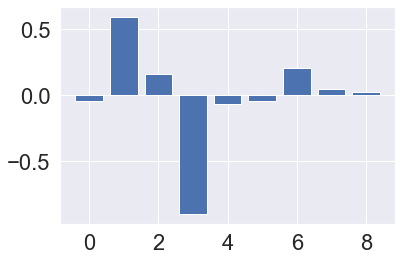

              precision    recall  f1-score   support

         400       0.50      0.42      0.45        24
         405       0.26      0.33      0.29        15
         410       0.24      0.22      0.23        23
         415       0.50      0.56      0.53        18

    accuracy                           0.38        80
   macro avg       0.38      0.38      0.38        80
weighted avg       0.38      0.38      0.38        80

Feature: 0, Score: -0.38489
Feature: 1, Score: -0.14903
Feature: 2, Score: 0.34946
Feature: 3, Score: -0.91375
Feature: 4, Score: 0.08799
Feature: 5, Score: -0.13610
Feature: 6, Score: 0.16279
Feature: 7, Score: -0.12979
Feature: 8, Score: -0.12467


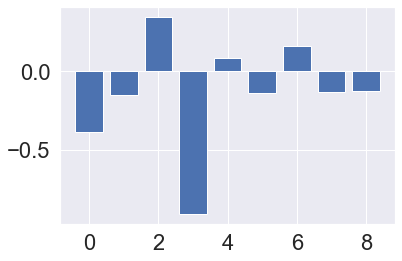

              precision    recall  f1-score   support

         400       0.55      0.61      0.58        18
         405       0.32      0.60      0.41        10
         410       0.43      0.39      0.41        23
         415       0.55      0.38      0.45        29

    accuracy                           0.46        80
   macro avg       0.46      0.50      0.46        80
weighted avg       0.49      0.46      0.46        80

Feature: 0, Score: 0.13902
Feature: 1, Score: 0.76797
Feature: 2, Score: -0.29444
Feature: 3, Score: -0.90093
Feature: 4, Score: 0.06864
Feature: 5, Score: -0.16413
Feature: 6, Score: 0.12693
Feature: 7, Score: -0.03582
Feature: 8, Score: -0.09366


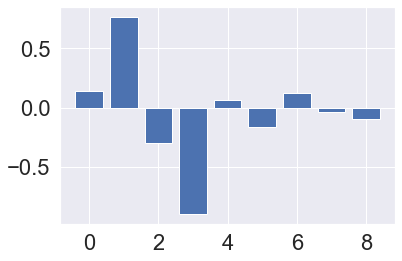

              precision    recall  f1-score   support

         400       0.63      0.60      0.62        20
         405       0.15      0.21      0.18        14
         410       0.33      0.33      0.33        21
         415       0.50      0.40      0.44        25

    accuracy                           0.40        80
   macro avg       0.40      0.39      0.39        80
weighted avg       0.43      0.40      0.41        80

Feature: 0, Score: 0.14118
Feature: 1, Score: 0.76730
Feature: 2, Score: -0.13490
Feature: 3, Score: -0.74825
Feature: 4, Score: -0.00622
Feature: 5, Score: -0.21682
Feature: 6, Score: 0.22677
Feature: 7, Score: -0.09755
Feature: 8, Score: -0.09819


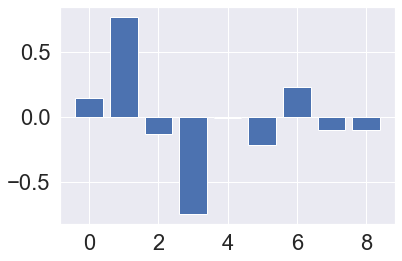

              precision    recall  f1-score   support

         400       0.74      0.48      0.58        29
         405       0.00      0.00      0.00        17
         410       0.10      0.15      0.12        13
         415       0.63      0.60      0.62        20

    accuracy                           0.35        79
   macro avg       0.37      0.31      0.33        79
weighted avg       0.45      0.35      0.39        79

Feature: 0, Score: -0.26913
Feature: 1, Score: 0.56150
Feature: 2, Score: 0.37988
Feature: 3, Score: -0.83424
Feature: 4, Score: 0.15069
Feature: 5, Score: -0.14443
Feature: 6, Score: 0.27129
Feature: 7, Score: -0.04066
Feature: 8, Score: -0.06853


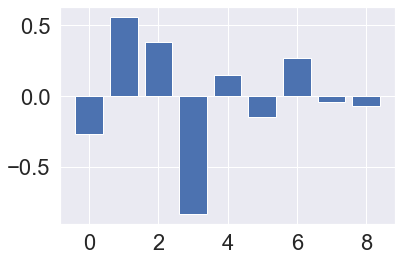

              precision    recall  f1-score   support

         400       0.79      0.58      0.67        26
         405       0.11      0.50      0.17         4
         410       0.45      0.40      0.43        25
         415       0.53      0.42      0.47        24

    accuracy                           0.47        79
   macro avg       0.47      0.47      0.43        79
weighted avg       0.57      0.47      0.50        79



In [24]:
# Split in K folds and standardize
K = 5
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Initialize model
    LR = LogisticRegression(penalty='none', random_state=13)

    # Fit model 
    LR.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = LR.predict(X_test_scaled)
    
    # Summarize feature importance
    importance = LR.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(classification_report(y_pred, y_test))

    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
    
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'log', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True) 

In [25]:
# Variance inflation factors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame([variance_inflation_factor(X_scaled, i) for i in range(9)], 
             columns=['VIF'], \
             index = ['offset', 'knee', 'exponent', 'center of frequency', 'power', 'bandwidth', \
                      'n peaks', 'R2', 'MAE']).round(1)

,VIF
offset,9.7
knee,1.8
exponent,11.7
center of frequency,1.0
power,1.9
bandwidth,1.1
n peaks,1.1
R2,1.6
MAE,2.3


## 2. Ridge classifier

Feature: 0, Score: -0.00649
Feature: 1, Score: 0.08817
Feature: 2, Score: 0.04732
Feature: 3, Score: -0.31839
Feature: 4, Score: -0.03347
Feature: 5, Score: -0.00175
Feature: 6, Score: 0.08707
Feature: 7, Score: 0.00946
Feature: 8, Score: -0.01155


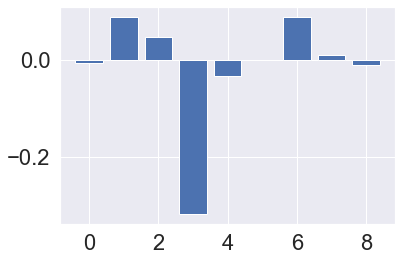

Alpha: 0.10772173450159434
              precision    recall  f1-score   support

         400       0.65      0.39      0.49        33
         405       0.00      0.00      0.00         3
         410       0.24      0.23      0.23        22
         415       0.60      0.55      0.57        22

    accuracy                           0.38        80
   macro avg       0.37      0.29      0.32        80
weighted avg       0.50      0.38      0.42        80

Feature: 0, Score: -0.04836
Feature: 1, Score: -0.01013
Feature: 2, Score: 0.02811
Feature: 3, Score: -0.26769
Feature: 4, Score: 0.01267
Feature: 5, Score: -0.02888
Feature: 6, Score: 0.04875
Feature: 7, Score: -0.05027
Feature: 8, Score: -0.04832


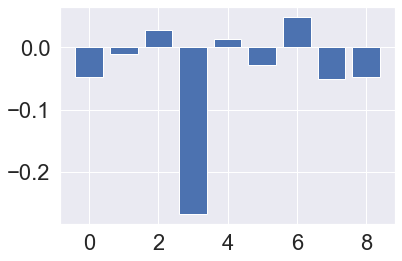

Alpha: 50.0
              precision    recall  f1-score   support

         400       0.60      0.46      0.52        26
         405       0.05      0.50      0.10         2
         410       0.33      0.41      0.37        17
         415       0.75      0.43      0.55        35

    accuracy                           0.44        80
   macro avg       0.43      0.45      0.38        80
weighted avg       0.60      0.44      0.49        80

Feature: 0, Score: -0.01398
Feature: 1, Score: 0.10608
Feature: 2, Score: -0.01657
Feature: 3, Score: -0.25626
Feature: 4, Score: 0.01521
Feature: 5, Score: -0.02765
Feature: 6, Score: 0.04071
Feature: 7, Score: -0.01996
Feature: 8, Score: -0.03892


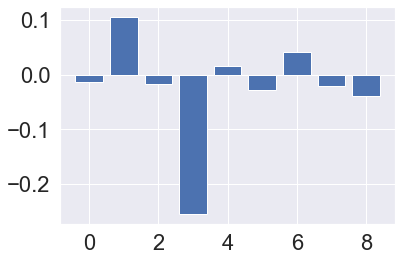

Alpha: 50.0
              precision    recall  f1-score   support

         400       0.79      0.58      0.67        26
         405       0.10      0.40      0.16         5
         410       0.43      0.53      0.47        17
         415       0.75      0.47      0.58        32

    accuracy                           0.51        80
   macro avg       0.52      0.49      0.47        80
weighted avg       0.65      0.51      0.56        80

Feature: 0, Score: 0.00719
Feature: 1, Score: 0.08604
Feature: 2, Score: -0.00229
Feature: 3, Score: -0.23524
Feature: 4, Score: -0.01495
Feature: 5, Score: -0.04814
Feature: 6, Score: 0.08038
Feature: 7, Score: -0.03680
Feature: 8, Score: -0.04640


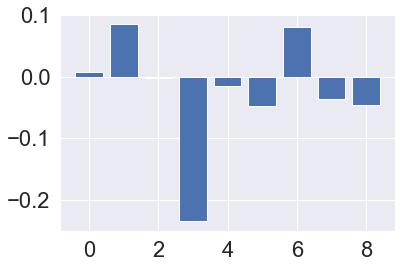

Alpha: 50.0
              precision    recall  f1-score   support

         400       0.84      0.44      0.58        36
         405       0.00      0.00      0.00         6
         410       0.10      0.20      0.13        10
         415       0.79      0.56      0.65        27

    accuracy                           0.42        79
   macro avg       0.43      0.30      0.34        79
weighted avg       0.67      0.42      0.50        79

Feature: 0, Score: -0.12070
Feature: 1, Score: 0.04273
Feature: 2, Score: 0.17212
Feature: 3, Score: -0.28426
Feature: 4, Score: 0.05553
Feature: 5, Score: -0.02603
Feature: 6, Score: 0.10860
Feature: 7, Score: -0.02725
Feature: 8, Score: -0.04580


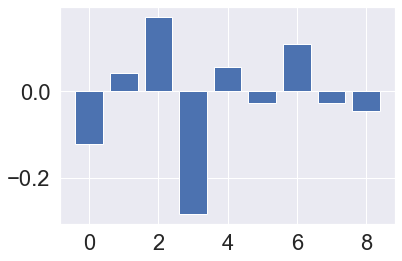

Alpha: 0.10772173450159434
              precision    recall  f1-score   support

         400       0.79      0.50      0.61        30
         405       0.11      0.50      0.17         4
         410       0.36      0.47      0.41        17
         415       0.63      0.43      0.51        28

    accuracy                           0.47        79
   macro avg       0.47      0.47      0.43        79
weighted avg       0.61      0.47      0.51        79



In [26]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize Ridge hyperparameter λ 
    hyperparameters = {"alpha": 10**np.linspace(10,-2,10)*0.5} 
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RidgeClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    RC = RidgeClassifier(alpha=Grid.best_params_['alpha'], random_state=13)

    # Fit model 
    RC.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = RC.predict(X_test_scaled)

    # Summarize feature importance
    importance = RC.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print("Alpha:",Grid.best_params_['alpha'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
         
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'ridge', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 3. K-nearest neighbors

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: -0.00500
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


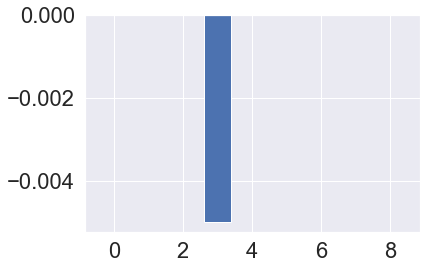

n_neighbors: 2
              precision    recall  f1-score   support

         400       0.80      0.46      0.58        35
         405       0.58      0.42      0.49        26
         410       0.24      0.33      0.28        15
         415       0.15      0.75      0.25         4

    accuracy                           0.44        80
   macro avg       0.44      0.49      0.40        80
weighted avg       0.59      0.44      0.48        80

Feature: 0, Score: 0.00500
Feature: 1, Score: 0.02250
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


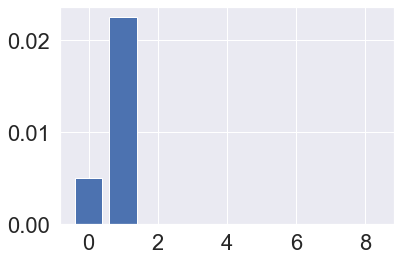

n_neighbors: 11
              precision    recall  f1-score   support

         400       0.45      0.60      0.51        15
         405       0.32      0.32      0.32        19
         410       0.38      0.28      0.32        29
         415       0.25      0.29      0.27        17

    accuracy                           0.35        80
   macro avg       0.35      0.37      0.36        80
weighted avg       0.35      0.35      0.34        80

Feature: 0, Score: 0.02500
Feature: 1, Score: 0.02500
Feature: 2, Score: 0.02250
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00250
Feature: 6, Score: 0.03000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


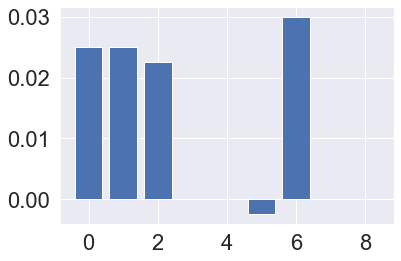

n_neighbors: 6
              precision    recall  f1-score   support

         400       0.68      0.57      0.62        23
         405       0.30      0.32      0.31        19
         410       0.29      0.29      0.29        21
         415       0.25      0.29      0.27        17

    accuracy                           0.38        80
   macro avg       0.38      0.37      0.37        80
weighted avg       0.40      0.38      0.38        80

Feature: 0, Score: -0.01266
Feature: 1, Score: 0.00253
Feature: 2, Score: -0.00253
Feature: 3, Score: -0.01772
Feature: 4, Score: -0.00253
Feature: 5, Score: 0.01772
Feature: 6, Score: 0.01266
Feature: 7, Score: -0.01013
Feature: 8, Score: 0.00000


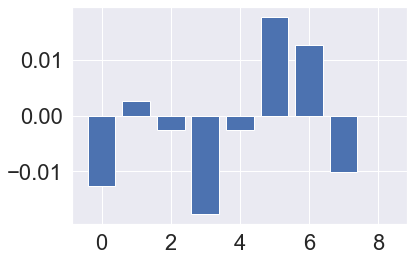

n_neighbors: 1
              precision    recall  f1-score   support

         400       0.47      0.45      0.46        20
         405       0.30      0.35      0.32        17
         410       0.38      0.42      0.40        19
         415       0.58      0.48      0.52        23

    accuracy                           0.43        79
   macro avg       0.43      0.43      0.43        79
weighted avg       0.44      0.43      0.44        79

Feature: 0, Score: 0.01266
Feature: 1, Score: -0.03544
Feature: 2, Score: 0.01266
Feature: 3, Score: -0.01519
Feature: 4, Score: 0.01519
Feature: 5, Score: 0.02025
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.02278
Feature: 8, Score: 0.01266


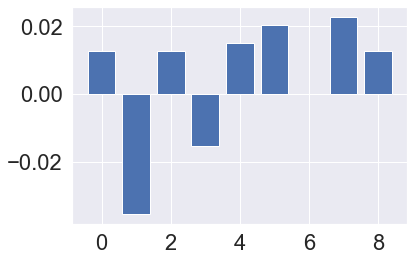

n_neighbors: 5
              precision    recall  f1-score   support

         400       0.79      0.52      0.62        29
         405       0.32      0.43      0.36        14
         410       0.45      0.56      0.50        18
         415       0.47      0.50      0.49        18

    accuracy                           0.51        79
   macro avg       0.51      0.50      0.49        79
weighted avg       0.56      0.51      0.52        79



In [27]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize hyperparameter K
    hyperparameters = {'n_neighbors':[i for i in range(1,20)]}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(KNeighborsClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
        
    # Initialize model
    KNN = KNeighborsClassifier(n_neighbors=Grid.best_params_['n_neighbors'])
    
    # Fit model 
    KNN.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = KNN.predict(X_test_scaled)
    
    # Summarize feature importance
    results = permutation_importance(KNN, X_test, y_test, scoring='accuracy')
    importance = results.importances_mean
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print('n_neighbors:',Grid.best_params_['n_neighbors'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'KNN', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 4. Multi-layer perceptron

In [28]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Optimize hyperparameters
    hyperparameters = {'activation':['identity', 'logistic', 'tanh', 'relu'], 'solver':['lbfgs', 'sgd', 'adam']}
    gkf=StratifiedKFold(n_splits=5, random_state=13)
    Grid = GridSearchCV(MLPClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    MLP = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500, activation = Grid.best_params_['activation'], \
                        solver=Grid.best_params_['solver'], shuffle=True, random_state=13)

    # Fit model 
    MLP.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = MLP.predict(X_test_scaled)

    # Output
    print(f"\033[1mActivation function: \033[0m{Grid.best_params_['activation']}")
    print(f"\033[1mSolver: \033[0m{Grid.best_params_['solver']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
     
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'MLP', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Activation function: relu
Solver: lbfgs
              precision    recall  f1-score   support

         400       0.60      0.50      0.55        24
         405       0.47      0.39      0.43        23
         410       0.33      0.50      0.40        14
         415       0.65      0.68      0.67        19

    accuracy                           0.51        80
   macro avg       0.51      0.52      0.51        80
weighted avg       0.53      0.51      0.52        80



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         400       0.50      0.91      0.65        11
         405       0.53      0.45      0.49        22
         410       0.48      0.45      0.47        22
         415       0.65      0.52      0.58        25

    accuracy                           0.54        80
   macro avg       0.54      0.58      0.54        80
weighted avg       0.55      0.54      0.53        80



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         400       0.58      0.65      0.61        17
         405       0.55      0.46      0.50        24
         410       0.52      0.44      0.48        25
         415       0.50      0.71      0.59        14

    accuracy                           0.54        80
   macro avg       0.54      0.56      0.54        80
weighted avg       0.54      0.54      0.53        80



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         400       0.63      0.44      0.52        27
         405       0.20      0.40      0.27        10
         410       0.57      0.50      0.53        24
         415       0.42      0.44      0.43        18

    accuracy                           0.46        79
   macro avg       0.46      0.45      0.44        79
weighted avg       0.51      0.46      0.47        79



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         400       0.53      0.59      0.56        17
         405       0.47      0.50      0.49        18
         410       0.45      0.48      0.47        21
         415       0.63      0.52      0.57        23

    accuracy                           0.52        79
   macro avg       0.52      0.52      0.52        79
weighted avg       0.53      0.52      0.52        79



## 5. Random forest

Feature: 0, Score: 0.07930
Feature: 1, Score: 0.08820
Feature: 2, Score: 0.08352
Feature: 3, Score: 0.37406
Feature: 4, Score: 0.10336
Feature: 5, Score: 0.04286
Feature: 6, Score: 0.03896
Feature: 7, Score: 0.09341
Feature: 8, Score: 0.09632


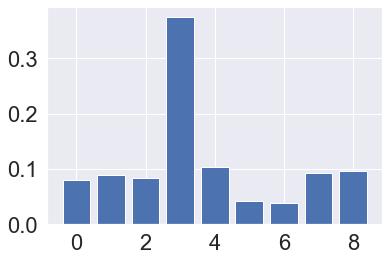

Number of trees: 1000
Maximum depth: 100
Maximum features per node split: auto
              precision    recall  f1-score   support

         400       0.70      0.64      0.67        22
         405       0.53      0.48      0.50        21
         410       0.48      0.56      0.51        18
         415       0.60      0.63      0.62        19

    accuracy                           0.57        80
   macro avg       0.58      0.57      0.57        80
weighted avg       0.58      0.57      0.58        80

Feature: 0, Score: 0.08637
Feature: 1, Score: 0.08575
Feature: 2, Score: 0.08396
Feature: 3, Score: 0.37070
Feature: 4, Score: 0.10401
Feature: 5, Score: 0.04809
Feature: 6, Score: 0.03066
Feature: 7, Score: 0.09268
Feature: 8, Score: 0.09780


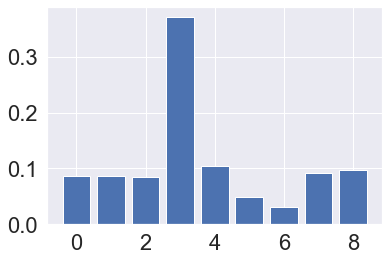

Number of trees: 1000
Maximum depth: 77
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         400       0.65      0.81      0.72        16
         405       0.53      0.77      0.62        13
         410       0.67      0.52      0.58        27
         415       0.60      0.50      0.55        24

    accuracy                           0.61        80
   macro avg       0.61      0.65      0.62        80
weighted avg       0.62      0.61      0.61        80

Feature: 0, Score: 0.08784
Feature: 1, Score: 0.08267
Feature: 2, Score: 0.08507
Feature: 3, Score: 0.36629
Feature: 4, Score: 0.10389
Feature: 5, Score: 0.05014
Feature: 6, Score: 0.03351
Feature: 7, Score: 0.09213
Feature: 8, Score: 0.09847


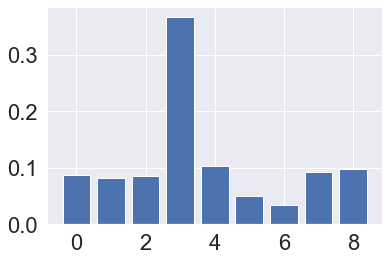

Number of trees: 2000
Maximum depth: 32
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         400       0.74      0.74      0.74        19
         405       0.30      0.46      0.36        13
         410       0.71      0.56      0.63        27
         415       0.60      0.57      0.59        21

    accuracy                           0.59        80
   macro avg       0.59      0.58      0.58        80
weighted avg       0.62      0.59      0.60        80

Feature: 0, Score: 0.09072
Feature: 1, Score: 0.08224
Feature: 2, Score: 0.08330
Feature: 3, Score: 0.36179
Feature: 4, Score: 0.10448
Feature: 5, Score: 0.04042
Feature: 6, Score: 0.03886
Feature: 7, Score: 0.09831
Feature: 8, Score: 0.09989


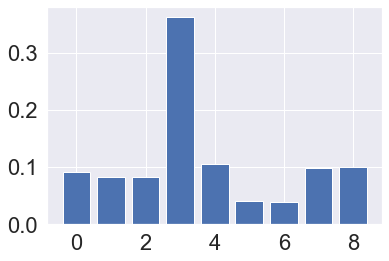

Number of trees: 2000
Maximum depth: 55
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         400       0.84      0.73      0.78        22
         405       0.55      0.52      0.54        21
         410       0.38      0.53      0.44        15
         415       0.68      0.62      0.65        21

    accuracy                           0.61        79
   macro avg       0.61      0.60      0.60        79
weighted avg       0.63      0.61      0.62        79

Feature: 0, Score: 0.08632
Feature: 1, Score: 0.08943
Feature: 2, Score: 0.08078
Feature: 3, Score: 0.36212
Feature: 4, Score: 0.10850
Feature: 5, Score: 0.03734
Feature: 6, Score: 0.03918
Feature: 7, Score: 0.09886
Feature: 8, Score: 0.09747


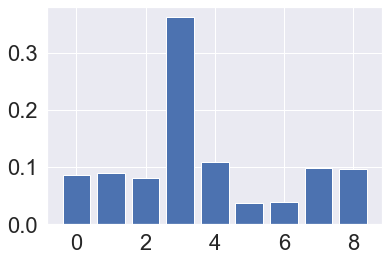

Number of trees: 200
Maximum depth: 100
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         400       0.68      0.72      0.70        18
         405       0.47      0.56      0.51        16
         410       0.59      0.57      0.58        23
         415       0.68      0.59      0.63        22

    accuracy                           0.61        79
   macro avg       0.61      0.61      0.61        79
weighted avg       0.61      0.61      0.61        79

Done in 884.3130106925964 seconds


In [29]:
tic = time.time()

# Split in K folds
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # Optimize hyperparameters
    hyperparameters = {"n_estimators": [200, 1000, 2000], \
                       "max_depth": [int(x) for x in np.linspace(10, 100, num = 5)],\
                       "max_features": ['auto', 'sqrt']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RandomForestClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train, y_train)
    
    # Initiating a RF classifier
    RFC = RandomForestClassifier(n_estimators = Grid.best_params_['n_estimators'], \
                                max_depth = Grid.best_params_['max_depth'], \
                                max_features = Grid.best_params_['max_features'], random_state = 13)  

    # Fit model
    RFC.fit(X_train, y_train)
  
    # performing predictions on the test dataset
    y_pred = RFC.predict(X_test)
    
    # Summarize feature importance
    importance = RFC.feature_importances_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(f"\033[1mNumber of trees: \033[0m{Grid.best_params_['n_estimators']}")
    print(f"\033[1mMaximum depth: \033[0m{Grid.best_params_['max_depth']}")
    print(f"\033[1mMaximum features per node split: \033[0m{Grid.best_params_['max_features']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'RF',  n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True) 
    
print(f'Done in {time.time()-tic} seconds')

# V. Statistics

In [30]:
# Typecast dataframe
performance[['classifier', 'n_channels', 'table']] = performance[['classifier', 'n_channels', 'table']].astype('category')
performance[['accuracy', 'precision', 'recall']] = performance[['accuracy', 'precision', 'recall']].astype('float32')

# Save as csv
df.to_csv('df_table5.csv')
performance.to_csv('performance_table5.csv')

# Display
display(performance)
display(df)

,accuracy,precision,recall,classifier,n_channels,table
0,0.37,0.38,0.37,log,13,5
1,0.17,0.20,0.17,log,13,5
2,0.35,0.35,0.35,log,13,5
3,0.33,0.34,0.33,log,13,5
4,0.40,0.51,0.40,log,13,5
5,0.37,0.38,0.37,ridge,13,5
6,0.20,0.22,0.20,ridge,13,5
7,0.35,0.42,0.35,ridge,13,5
8,0.40,0.45,0.40,ridge,13,5
9,0.40,0.53,0.40,ridge,13,5


,subject,day,target,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
0,S1,/Day1,400,-4.241769,-1.001322,0.000485,40.789368,0.144279,2.350276,1,0.663628,0.039957
1,S1,/Day1,405,-4.220107,-1.001587,0.000558,40.508125,0.133994,2.000000,2,0.699494,0.038891
2,S1,/Day2,405,-2.717287,-0.996706,0.000669,39.472469,0.335811,2.020042,2,0.631220,0.053354
3,S1,/Day2,410,-3.778546,-1.001125,0.000554,41.387703,0.113572,2.000000,4,0.494326,0.034774
4,S2,/Day1,400,-4.188694,-1.001813,0.000565,39.795048,0.130524,2.000000,2,0.904317,0.038631
...,...,...,...,...,...,...,...,...,...,...,...,...
393,S30,/Day1,415,-3.388001,-1.013027,0.003939,41.652428,0.125993,2.000000,2,0.906571,0.044781
394,S30,/Day2,400,-3.832783,-1.001861,0.000591,39.412014,0.066667,2.000000,1,0.848437,0.044143
395,S30,/Day2,405,-3.641878,-1.003031,0.000956,41.725098,0.076044,3.271244,2,0.875139,0.033721
396,S30,/Day2,410,-1.455021,-1.367692,0.100159,40.811443,0.072712,2.000000,3,0.907861,0.035224


In [31]:
# Mean
display(pd.concat([performance.groupby(['classifier', 'n_channels']).agg({'accuracy': ['mean']}),\
                   performance.groupby(['classifier', 'n_channels']).agg({'precision': ['mean']}),\
                   performance.groupby(['classifier', 'n_channels']).agg({'recall': ['mean']})], axis=1))

# Standard error
print('log 13')
display(np.std(performance[(performance['classifier']=='log') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('log 3')
display(np.std(performance[(performance['classifier']=='log') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('Ridge 13')
display(np.std(performance[(performance['classifier']=='ridge') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('Ridge 3')
display(np.std(performance[(performance['classifier']=='ridge') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('KNN 13')
display(np.std(performance[(performance['classifier']=='KNN') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('KNN 3')
display(np.std(performance[(performance['classifier']=='KNN') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('MLP 13')
display(np.std(performance[(performance['classifier']=='MLP') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('MLP 3')
display(np.std(performance[(performance['classifier']=='MLP') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('RF 13')
display(np.std(performance[(performance['classifier']=='RF') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('RF 3')
display(np.std(performance[(performance['classifier']=='RF') & (performance['n_channels']==3)], axis=0)/sqrt(5))

accuracy precision recall
                          mean      mean   mean
classifier n_channels                          
KNN        3             0.422     0.468  0.422
           13            0.304     0.344  0.304
MLP        3             0.514     0.532  0.514
           13            0.402     0.418  0.402
RF         3             0.598     0.612  0.598
           13            0.528     0.564  0.528
log        3             0.412     0.464  0.412
           13            0.324     0.356  0.324
ridge      3             0.444     0.606  0.444
           13            0.344     0.400  0.344

log 13


accuracy     0.035956
precision    0.044236
recall       0.035956
dtype: float64

log 3


accuracy     0.020669
precision    0.028510
recall       0.020669
dtype: float64

Ridge 13


accuracy     0.033299
precision    0.045869
recall       0.033299
dtype: float64

Ridge 3


accuracy     0.019718
precision    0.026321
recall       0.019718
dtype: float64

KNN 13


accuracy     0.024265
precision    0.025393
recall       0.024265
dtype: float64

KNN 3


accuracy     0.024560
precision    0.041318
recall       0.024560
dtype: float64

MLP 13


accuracy     0.019880
precision    0.021799
recall       0.019880
dtype: float64

MLP 3


accuracy     0.013145
precision    0.005933
recall       0.013145
dtype: float64

RF 13


accuracy     0.027335
precision    0.026773
recall       0.027335
dtype: float64

RF 3


accuracy     0.007155
precision    0.007694
recall       0.007155
dtype: float64

In [32]:
## ANOVA and Tukey's test 
# Accuracy
model = ols('accuracy ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['accuracy'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['accuracy'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

# Precision
model = ols('precision ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['precision'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['precision'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

# Recall
model = ols('recall ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['recall'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['recall'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

,sum_sq,df,F,PR(>F)
C(classifier),0.280988,4.0,19.459002,5.864906e-09
C(n_channels),0.119072,1.0,32.983930,1.085264e-06
C(classifier):C(n_channels),0.003708,4.0,0.256787,9.037992e-01
Residual,0.144400,40.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN    MLP    0.095 0.0612 -0.0029  0.1929  False
   KNN     RF      0.2  0.001  0.1021  0.2979   True
   KNN    log    0.005    0.9 -0.0929  0.1029  False
   KNN  ridge    0.031 0.8926 -0.0669  0.1289  False
   MLP     RF    0.105 0.0301  0.0071  0.2029   True
   MLP    log    -0.09 0.0853 -0.1879  0.0079  False
   MLP  ridge   -0.064 0.3553 -0.1619  0.0339  False
    RF    log   -0.195  0.001 -0.2929 -0.0971   True
    RF  ridge   -0.169  0.001 -0.2669 -0.0711   True
   log  ridge    0.026    0.9 -0.0719  0.1239  False
----------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     3     13  -0.0976 0.001 -0.1514 -0.0438   True
--------------------------------------------------

,sum_sq,df,F,PR(>F)
C(classifier),0.225292,4.0,9.790197,0.000013
C(n_channels),0.180000,1.0,31.288027,0.000002
C(classifier):C(n_channels),0.031940,4.0,1.387972,0.255464
Residual,0.230120,40.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   KNN    MLP    0.069 0.5284 -0.057  0.195  False
   KNN     RF    0.182 0.0015  0.056  0.308   True
   KNN    log    0.004    0.9 -0.122   0.13  False
   KNN  ridge    0.097 0.2027 -0.029  0.223  False
   MLP     RF    0.113 0.0977 -0.013  0.239  False
   MLP    log   -0.065 0.5784 -0.191  0.061  False
   MLP  ridge    0.028    0.9 -0.098  0.154  False
    RF    log   -0.178  0.002 -0.304 -0.052   True
    RF  ridge   -0.085  0.323 -0.211  0.041  False
   log  ridge    0.093 0.2387 -0.033  0.219  False
--------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     3     13    -0.12 0.001 -0.1773 -0.0627   True
---------------------------------------------------


,sum_sq,df,F,PR(>F)
C(classifier),0.280988,4.0,19.459002,5.864906e-09
C(n_channels),0.119072,1.0,32.983930,1.085264e-06
C(classifier):C(n_channels),0.003708,4.0,0.256787,9.037992e-01
Residual,0.144400,40.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN    MLP    0.095 0.0612 -0.0029  0.1929  False
   KNN     RF      0.2  0.001  0.1021  0.2979   True
   KNN    log    0.005    0.9 -0.0929  0.1029  False
   KNN  ridge    0.031 0.8926 -0.0669  0.1289  False
   MLP     RF    0.105 0.0301  0.0071  0.2029   True
   MLP    log    -0.09 0.0853 -0.1879  0.0079  False
   MLP  ridge   -0.064 0.3553 -0.1619  0.0339  False
    RF    log   -0.195  0.001 -0.2929 -0.0971   True
    RF  ridge   -0.169  0.001 -0.2669 -0.0711   True
   log  ridge    0.026    0.9 -0.0719  0.1239  False
----------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     3     13  -0.0976 0.001 -0.1514 -0.0438   True
--------------------------------------------------